### Notebook 05: Neural Network

This notebook builds a Multi-Layer Perceptron neural network for classification. 

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
import joblib

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load preprocessed data
preprocessed_file = r'C:\Users\anitr\AAI590_Capstone\AAI590_Capstone_AH\Data\ea_modelset\eamodelset\dataset\preprocessed_models.csv'
models_df = pd.read_csv(preprocessed_file)
models_df.head()

,id,name,duplicateCount,elementCount,relationshipCount,viewCount,num_formats,hasWarning,hasDuplicate,rel_elem_ratio,...,language_pl,language_pt,language_ru,language_sl,language_sv,language_tl,language_vi,language_yo,language_zh,arb_outcome
0,id-48fb3807bfa249a9bae607b6a92cc390,LAE,0,142,296,24,4,0,0,2.084507,...,0,0,0,0,0,0,0,0,0,0
1,4cc127d7-6937-42e8-99fb-19f0f6f4991a,Baseline Media Production,0,22,28,1,4,0,0,1.272727,...,0,0,0,0,0,0,0,0,0,1
2,_7RWQ8CqVEey-A40W5C_9dw,buhService,0,55,41,3,4,0,0,0.745455,...,0,0,1,0,0,0,0,0,0,0
3,3846c562-eab4-4e07-aa95-87703e0e0e69,Data model test,0,15,11,1,2,0,0,0.733333,...,0,0,0,0,0,0,0,0,0,1
4,_ay028PGjEeqygJczXaaxEQ,payments-arch,0,18,20,1,4,0,0,1.111111,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# Define arb_outcome as target variable (y) and features (X)
X = models_df.drop(columns=['name','id','arb_outcome'])
y = models_df['arb_outcome']

# Check shape of X and y
print(f"Models DataFrame shape: {models_df.shape}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Models DataFrame shape: (978, 41)
Features shape: (978, 38)
Target shape: (978,)


In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (782, 38), (782,)
Test set shape: (196, 38), (196,)


In [6]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### The Basline MLP Classifier consists of two hidden layers with 64 and 32 neurons each, using the ReLU activation function and the Adam optimizer. The model is trained for 300 epochs with a batch size of 32. It uses L2 regularization and a d adaptive learning rate. 

In [7]:
# Baseline MLP Classifier
mlp_baseline = MLPClassifier(
    random_state=42, 
    max_iter=300,
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=1e-3,
    batch_size=32,
    learning_rate='adaptive'
)

# Train baseline model
mlp_baseline.fit(X_train_scaled, y_train)

# Evaluate baseline model
y_pred_baseline = mlp_baseline.predict(X_test_scaled)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline MLP Classifier Accuracy: {accuracy_baseline:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_baseline))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))


Baseline MLP Classifier Accuracy: 0.9796
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        50
           1       0.97      0.99      0.98       105
           2       1.00      0.98      0.99        41

    accuracy                           0.98       196
   macro avg       0.98      0.98      0.98       196
weighted avg       0.98      0.98      0.98       196

Confusion Matrix:
[[ 48   2   0]
 [  1 104   0]
 [  0   1  40]]


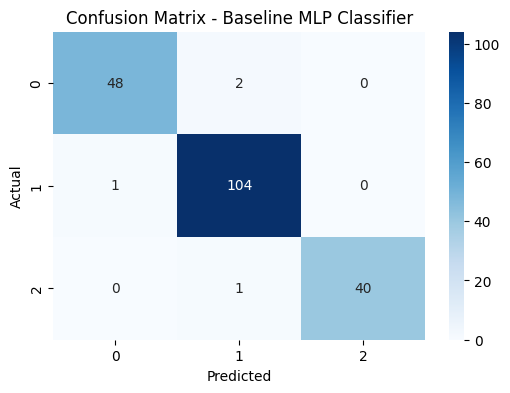

In [8]:
# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline MLP Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


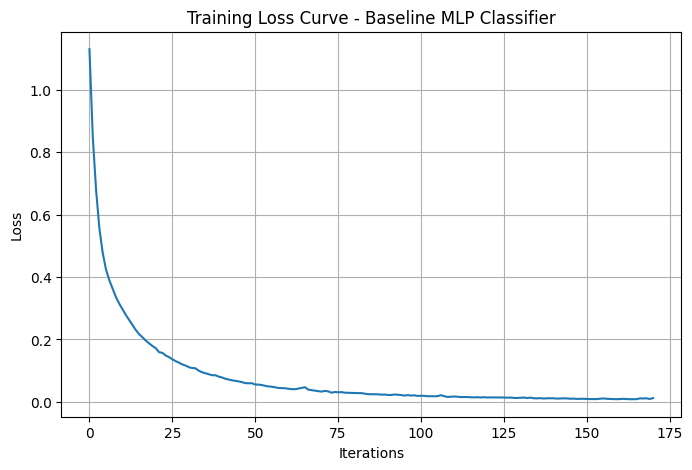

In [9]:
# Visualize training loss curve
plt.figure(figsize=(8, 5))
plt.plot(mlp_baseline.loss_curve_)  
plt.title('Training Loss Curve - Baseline MLP Classifier')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()


### NEURAL NETWORK MODEL - HYPERPARAMETER TUNING WITH OPTUNA

In [17]:
def mlp_objective(trial):
    n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 2)
    hidden_layer_sizes = []
    for i in range(n_hidden_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 16, 128, step=16)
        hidden_layer_sizes.append(n_units)  
    hidden_layer_sizes = tuple(hidden_layer_sizes)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = 'adam' 
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)
    learning_rate = 'adaptive'
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Create MLPClassifier with suggested hyperparameters
    mlp = MLPClassifier(
        random_state=42,
        max_iter=300,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver='adam',
        alpha=alpha,
        learning_rate='adaptive',
        learning_rate_init=learning_rate_init,
        batch_size=batch_size,
        early_stopping=True,
        n_iter_no_change=10,
    )
    
    # Perform cross-validation
    scores = cross_val_score(mlp, X_train_scaled, y_train, cv=3, scoring='f1_macro', n_jobs=-1)
    return scores.mean()    

# Optimize hyperparameters with Optuna
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(mlp_objective, n_trials=25, show_progress_bar=True)
print("Best hyperparameters:", study_mlp.best_params)
print("Best F1 Macro Score:", study_mlp.best_value)


[I 2025-12-07 19:16:17,574] A new study created in memory with name: no-name-5130a49e-08f8-4cac-9837-2634d76d1de7
Best trial: 0. Best value: 0.883599:   8%|▊         | 2/25 [00:00<00:02,  7.77it/s]

[I 2025-12-07 19:16:17,684] Trial 0 finished with value: 0.8835989854599876 and parameters: {'n_hidden_layers': 1, 'n_units_l0': 128, 'activation': 'relu', 'alpha': 0.0035861185960480097, 'learning_rate_init': 0.005074591833951705, 'batch_size': 64}. Best is trial 0 with value: 0.8835989854599876.
[I 2025-12-07 19:16:17,826] Trial 1 finished with value: 0.7765358887980219 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'activation': 'relu', 'alpha': 0.00019339203089735563, 'learning_rate_init': 0.0814017561898356, 'batch_size': 16}. Best is trial 0 with value: 0.8835989854599876.


Best trial: 0. Best value: 0.883599:  16%|█▌        | 4/25 [00:00<00:01, 10.64it/s]

[I 2025-12-07 19:16:17,894] Trial 2 finished with value: 0.7024297843296639 and parameters: {'n_hidden_layers': 1, 'n_units_l0': 96, 'activation': 'relu', 'alpha': 0.00014082677385984058, 'learning_rate_init': 0.0005063928131044898, 'batch_size': 64}. Best is trial 0 with value: 0.8835989854599876.
[I 2025-12-07 19:16:17,972] Trial 3 finished with value: 0.855345237279273 and parameters: {'n_hidden_layers': 1, 'n_units_l0': 128, 'activation': 'tanh', 'alpha': 0.0001856419183461236, 'learning_rate_init': 0.007412533295566562, 'batch_size': 64}. Best is trial 0 with value: 0.8835989854599876.


Best trial: 4. Best value: 0.895166:  24%|██▍       | 6/25 [00:00<00:02,  9.23it/s]

[I 2025-12-07 19:16:18,112] Trial 4 finished with value: 0.8951660572472152 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 128, 'n_units_l1': 112, 'activation': 'tanh', 'alpha': 0.0007524931969831508, 'learning_rate_init': 0.010144419143646829, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:18,221] Trial 5 finished with value: 0.7810240212432061 and parameters: {'n_hidden_layers': 1, 'n_units_l0': 128, 'activation': 'tanh', 'alpha': 0.0002347262953380973, 'learning_rate_init': 0.00013355103351324706, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.


Best trial: 4. Best value: 0.895166:  36%|███▌      | 9/25 [00:00<00:01, 10.10it/s]

[I 2025-12-07 19:16:18,350] Trial 6 finished with value: 0.8774846026287303 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 64, 'n_units_l1': 128, 'activation': 'tanh', 'alpha': 0.00027384175207713547, 'learning_rate_init': 0.0024498967717310497, 'batch_size': 64}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:18,438] Trial 7 finished with value: 0.8823276687250404 and parameters: {'n_hidden_layers': 1, 'n_units_l0': 64, 'activation': 'tanh', 'alpha': 0.0005996645700101381, 'learning_rate_init': 0.045715475129446105, 'batch_size': 32}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:18,508] Trial 8 finished with value: 0.8435485478576488 and parameters: {'n_hidden_layers': 1, 'n_units_l0': 48, 'activation': 'relu', 'alpha': 0.004593627647047769, 'learning_rate_init': 0.003211576869414199, 'batch_size': 64}. Best is trial 4 with value: 0.8951660572472152.


Best trial: 4. Best value: 0.895166:  44%|████▍     | 11/25 [00:01<00:01, 10.46it/s]

[I 2025-12-07 19:16:18,606] Trial 9 finished with value: 0.714530144108235 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 112, 'n_units_l1': 32, 'activation': 'tanh', 'alpha': 0.0020124672099538416, 'learning_rate_init': 0.0001271377395319507, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:18,687] Trial 10 finished with value: 0.8908071947930547 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 16, 'n_units_l1': 128, 'activation': 'tanh', 'alpha': 1.2577470802675003e-05, 'learning_rate_init': 0.016849973486413025, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:18,760] Trial 11 finished with value: 0.8859049198366145 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 16, 'n_units_l1': 128, 'activation': 'tanh', 'alpha': 3.291150046759525e-05, 'learning_rate_init': 0.019677322351537744, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.


Best trial: 4. Best value: 0.895166:  52%|█████▏    | 13/25 [00:01<00:01, 11.69it/s]

[I 2025-12-07 19:16:18,821] Trial 12 finished with value: 0.8723775559975054 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 16, 'n_units_l1': 96, 'activation': 'tanh', 'alpha': 1.0031100502589333e-05, 'learning_rate_init': 0.015521444276177817, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:18,946] Trial 13 finished with value: 0.8420978462478944 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 96, 'n_units_l1': 96, 'activation': 'tanh', 'alpha': 0.0008102416400181602, 'learning_rate_init': 0.0011875483307365483, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.


Best trial: 4. Best value: 0.895166:  60%|██████    | 15/25 [00:01<00:01,  9.34it/s]

[I 2025-12-07 19:16:19,122] Trial 14 finished with value: 0.8863756214902732 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 32, 'n_units_l1': 128, 'activation': 'tanh', 'alpha': 5.449126336873774e-05, 'learning_rate_init': 0.017535235955656404, 'batch_size': 16}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:19,245] Trial 15 finished with value: 0.8869043420764299 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 80, 'n_units_l1': 96, 'activation': 'tanh', 'alpha': 1.0612269431595992e-05, 'learning_rate_init': 0.03511321694713964, 'batch_size': 32}. Best is trial 4 with value: 0.8951660572472152.


Best trial: 4. Best value: 0.895166:  72%|███████▏  | 18/25 [00:01<00:00,  9.23it/s]

[I 2025-12-07 19:16:19,338] Trial 16 finished with value: 0.8809715634987908 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 48, 'n_units_l1': 112, 'activation': 'tanh', 'alpha': 0.0010773705683584627, 'learning_rate_init': 0.008966790462599322, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:19,450] Trial 17 finished with value: 0.8579692067172758 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 96, 'n_units_l1': 64, 'activation': 'tanh', 'alpha': 6.12717903466049e-05, 'learning_rate_init': 0.0969366804230743, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.


Best trial: 4. Best value: 0.895166:  80%|████████  | 20/25 [00:02<00:00,  8.79it/s]

[I 2025-12-07 19:16:19,532] Trial 18 finished with value: 0.7525253683352745 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 32, 'n_units_l1': 80, 'activation': 'relu', 'alpha': 2.4457060531437145e-05, 'learning_rate_init': 0.0012531037835734936, 'batch_size': 128}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:19,698] Trial 19 finished with value: 0.895024252807035 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 80, 'n_units_l1': 32, 'activation': 'tanh', 'alpha': 0.00748597628575558, 'learning_rate_init': 0.0313914933231045, 'batch_size': 32}. Best is trial 4 with value: 0.8951660572472152.


Best trial: 4. Best value: 0.895166:  88%|████████▊ | 22/25 [00:02<00:00,  8.79it/s]

[I 2025-12-07 19:16:19,801] Trial 20 finished with value: 0.8810896896352771 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 80, 'n_units_l1': 16, 'activation': 'tanh', 'alpha': 0.009906100748113402, 'learning_rate_init': 0.046143420593528314, 'batch_size': 32}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:19,923] Trial 21 finished with value: 0.8893168819325826 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 112, 'n_units_l1': 48, 'activation': 'tanh', 'alpha': 0.009871724526987901, 'learning_rate_init': 0.011026923617769956, 'batch_size': 32}. Best is trial 4 with value: 0.8951660572472152.


Best trial: 4. Best value: 0.895166:  92%|█████████▏| 23/25 [00:02<00:00,  8.44it/s]

[I 2025-12-07 19:16:20,056] Trial 22 finished with value: 0.8816016167669769 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 48, 'n_units_l1': 112, 'activation': 'tanh', 'alpha': 0.0004748905610648016, 'learning_rate_init': 0.037000291257960706, 'batch_size': 32}. Best is trial 4 with value: 0.8951660572472152.


Best trial: 4. Best value: 0.895166: 100%|██████████| 25/25 [00:02<00:00,  8.67it/s]

[I 2025-12-07 19:16:20,294] Trial 23 finished with value: 0.8935744819314358 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 112, 'n_units_l1': 16, 'activation': 'tanh', 'alpha': 0.002468935768062185, 'learning_rate_init': 0.004922145552699441, 'batch_size': 16}. Best is trial 4 with value: 0.8951660572472152.
[I 2025-12-07 19:16:20,458] Trial 24 finished with value: 0.8862774454732331 and parameters: {'n_hidden_layers': 2, 'n_units_l0': 112, 'n_units_l1': 16, 'activation': 'tanh', 'alpha': 0.0014418315358349515, 'learning_rate_init': 0.004100145827792094, 'batch_size': 16}. Best is trial 4 with value: 0.8951660572472152.
Best hyperparameters: {'n_hidden_layers': 2, 'n_units_l0': 128, 'n_units_l1': 112, 'activation': 'tanh', 'alpha': 0.0007524931969831508, 'learning_rate_init': 0.010144419143646829, 'batch_size': 128}
Best F1 Macro Score: 0.8951660572472152


In [18]:
# Train MLPClassifier with best hyperparameters
best_params = study_mlp.best_params
n_hidden_layers = best_params.pop('n_hidden_layers')
hidden_layer_sizes = []
for i in range(n_hidden_layers):
    n_units = best_params.pop(f'n_units_l{i}')
    hidden_layer_sizes.append(n_units)
hidden_layer_sizes = tuple(hidden_layer_sizes)
mlp_tuned = MLPClassifier(
    random_state=42,
    max_iter=300,
    hidden_layer_sizes=hidden_layer_sizes,
    activation=best_params['activation'],
    solver='adam',
    alpha=best_params['alpha'],
    learning_rate='adaptive',
    learning_rate_init=best_params['learning_rate_init'],
    batch_size=best_params['batch_size'],
    early_stopping=True,
    n_iter_no_change=10,
)
mlp_tuned.fit(X_train_scaled, y_train)

# Evaluate tuned MLPClassifier
y_pred_tuned = mlp_tuned.predict(X_test_scaled)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned MLP Classifier Accuracy: {accuracy_tuned:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))


Tuned MLP Classifier Accuracy: 0.9949
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.99      1.00       105
           2       1.00      1.00      1.00        41

    accuracy                           0.99       196
   macro avg       0.99      1.00      1.00       196
weighted avg       0.99      0.99      0.99       196

Confusion Matrix:
[[ 50   0   0]
 [  1 104   0]
 [  0   0  41]]


In [19]:
# Create comparison table of model accuracies
performance_data = {
    'Model': ['Baseline MLP', 'Tuned MLP'],
    'Accuracy': [accuracy_baseline, accuracy_tuned]
}   
performance_df = pd.DataFrame(performance_data)
print(performance_df)


          Model  Accuracy
0  Baseline MLP  0.979592
1     Tuned MLP  0.994898


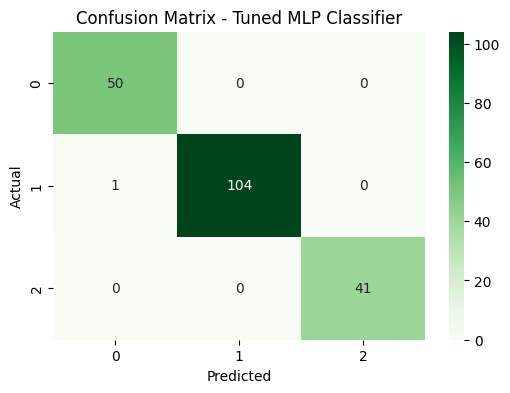

In [21]:
# Visualize confusion matrix for tuned model
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Tuned MLP Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
    


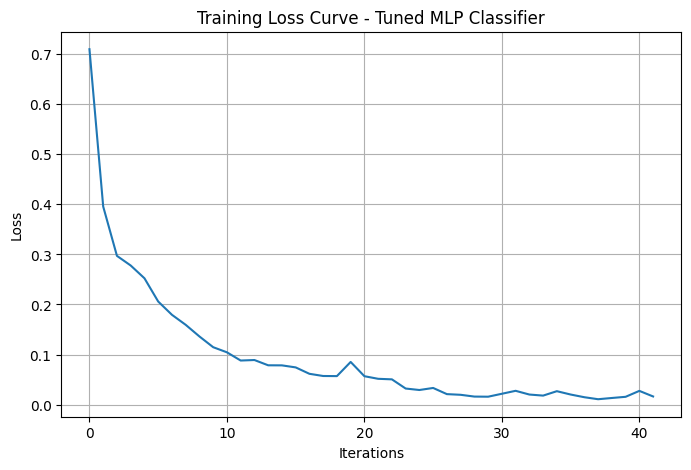

In [22]:
# Visualize training loss curve for tuned model
plt.figure(figsize=(8, 5))
plt.plot(mlp_tuned.loss_curve_)  
plt.title('Training Loss Curve - Tuned MLP Classifier')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [29]:
# Save tuned models
model_dir = r'C:\Users\anitr\AAI590_Capstone\AAI590_Capstone_AH\Models\tuned_and_hybrid_models'
os.makedirs(model_dir, exist_ok=True)
joblib.dump(mlp_tuned, os.path.join(model_dir, 'mlp_tuned.pkl'))
print("Tuned model saved successfully.")

Tuned model saved successfully.


In [30]:
# Save baseline models
baseline_model_dir = r'C:\Users\anitr\AAI590_Capstone\AAI590_Capstone_AH\Models\baseline_models'
os.makedirs(baseline_model_dir, exist_ok=True)
joblib.dump(mlp_baseline, os.path.join(baseline_model_dir, 'mlp_baseline.pkl'))
print("Baseline model saved successfully.")

Baseline model saved successfully.
